# 🚛 Optimización de Rutas con Aprendizaje por Refuerzo (Q-Learning)
Este cuaderno implementa un agente inteligente que aprende rutas óptimas entre ciudades de Colombia, minimizando las distancias y partiendo desde Bogotá como punto central de distribución.

## 📘 ¿Qué es el Aprendizaje por Refuerzo?
El **Aprendizaje por Refuerzo (RL)** es una técnica de machine learning en la que un **agente** aprende interactuando con un **entorno**, tomando decisiones secuenciales para maximizar una **recompensa acumulada**.

**Q-Learning** es un algoritmo de RL basado en tablas donde se actualiza un valor Q para cada par (estado, acción), aprendiendo qué decisiones son mejores en el tiempo.

- **Estado**: ciudad actual
- **Acción**: próxima ciudad a visitar
- **Recompensa**: negativa a la distancia (queremos minimizarla)


## 📚 Paso 1: Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.distance import geodesic
import random

## 📂 Paso 2: Cargar nodos y matriz de distancias

In [2]:
from google.colab import files
import io

uploaded = files.upload()
for archivo in uploaded:
    if 'nodos' in archivo:
        df = pd.read_csv(io.BytesIO(uploaded[archivo]))
    elif 'matriz' in archivo:
        distancias = pd.read_csv(io.BytesIO(uploaded[archivo]), index_col=0)
df.head()

Saving matriz_distancias_colombia.csv to matriz_distancias_colombia.csv
Saving nodos_colombia_ruteo.csv to nodos_colombia_ruteo.csv


,Ciudad,Latitud,Longitud,Demanda
0,Bogotá,4.7110,-74.0721,0
1,Medellín,6.2442,-75.5812,9
2,Cali,3.4516,-76.5320,7
3,Barranquilla,10.9685,-74.7813,2
4,Cartagena,10.3910,-75.4794,4


## 🗺️ Paso 3: Visualizar las ciudades en un mapa interactivo

In [3]:
mapa = folium.Map(location=[4.5, -74.1], zoom_start=6)
for i, row in df.iterrows():
    color = 'red' if row['Demanda'] == 0 else 'blue'
    folium.Marker([row['Latitud'], row['Longitud']], tooltip=row['Ciudad'], icon=folium.Icon(color=color)).add_to(mapa)
mapa

# Funcionamiento del algoritmo Q-Learning aplicado al problema de rutas entre ciudades

La siguiente explicación describe cómo se entrena un agente para aprender rutas eficientes entre ciudades utilizando el algoritmo de Q-Learning. La matriz Q resultante muestra los valores aprendidos para transitar de una ciudad a otra, donde cada valor representa el beneficio estimado de tomar esa acción.

---

## Inicialización

- Se crea una tabla `q_table` de ceros con dimensiones \( n \times n \), donde \( n \) es el número de ciudades.
- Se definen los parámetros principales del aprendizaje:
  - `learning_rate` (\( \alpha \)): tasa de aprendizaje, define cuánto se actualiza el valor Q.
  - `discount` (\( \gamma \)): factor de descuento, mide la importancia de las recompensas futuras.
  - `epsilon`: probabilidad de realizar exploración aleatoria.
  - `episodios`: número total de iteraciones o recorridos simulados desde la ciudad de inicio (Bogotá).

---

## Ejecución por episodios

- En cada episodio, el agente comienza en Bogotá (índice 0).
- Se va construyendo una ruta visitando ciudades no repetidas (`visitados`) hasta cubrir todas.

---

## Selección de acción

- Se identifican las ciudades no visitadas en ese episodio.
- Con probabilidad `epsilon`, se selecciona una ciudad al azar (exploración).
- Con probabilidad `1 - epsilon`, se selecciona la ciudad con el mayor valor Q conocido (explotación).

---

## Actualización de la tabla Q

Para cada movimiento del agente:

- Se calcula la recompensa como el **negativo de la distancia** entre las ciudades, es decir:
  
  \[
  \text{recompensa} = -\text{distancia}
  \]

- Se actualiza el valor Q de la siguiente forma:

  \[
  Q(s, a) \leftarrow Q(s, a) + \alpha \left[r + \gamma \cdot \max Q(s', \cdot) - Q(s, a)\right]
  \]

  Donde:
  - \( s \): ciudad actual.
  - \( a \): ciudad elegida (acción).
  - \( r \): recompensa recibida.
  - \( s' \): nueva ciudad (estado siguiente).
  - \( \alpha \): tasa de aprendizaje.
  - \( \gamma \): factor de descuento.

---

## Transición al nuevo estado

- El agente añade la ciudad visitada al conjunto de `visitados`.
- Se repite el proceso desde la nueva ciudad hasta completar la visita a todas las ciudades.

---

## Resultado

- La matriz Q final contiene los valores aprendidos para cada posible transición entre ciudades.
- Valores más cercanos a cero indican rutas más convenientes (menor distancia).
- Esta tabla puede ser utilizada para construir una **ruta óptima** que minimice la distancia total entre ciudades.

---

Se puede extender este algoritmo para extraer rutas óptimas, visualizar el proceso de aprendizaje o evaluar distintas políticas de exploración.

## ⚙️ Paso 4: Inicializar Q-Learning

In [4]:
n_ciudades = len(df)
q_table = np.zeros((n_ciudades, n_ciudades))
learning_rate = 0.1
discount = 0.8
epsilon = 0.2
episodios = 1000

## 🧠 Paso 5: Entrenar agente con Q-Learning

In [5]:
for ep in range(episodios):
    estado = 0  # Bogotá
    visitados = set([estado])
    while len(visitados) < n_ciudades:
        opciones = [i for i in range(n_ciudades) if i not in visitados]
        if random.random() < epsilon:
            accion = random.choice(opciones)
        else:
            accion = opciones[np.argmax(q_table[estado, opciones])]
        recompensa = -distancias.iloc[estado, accion]
        max_q = np.max(q_table[accion])
        q_table[estado, accion] += learning_rate * (recompensa + discount * max_q - q_table[estado, accion])
        visitados.add(accion)
        estado = accion

## 📈 Paso 6: Visualizar tabla Q aprendida

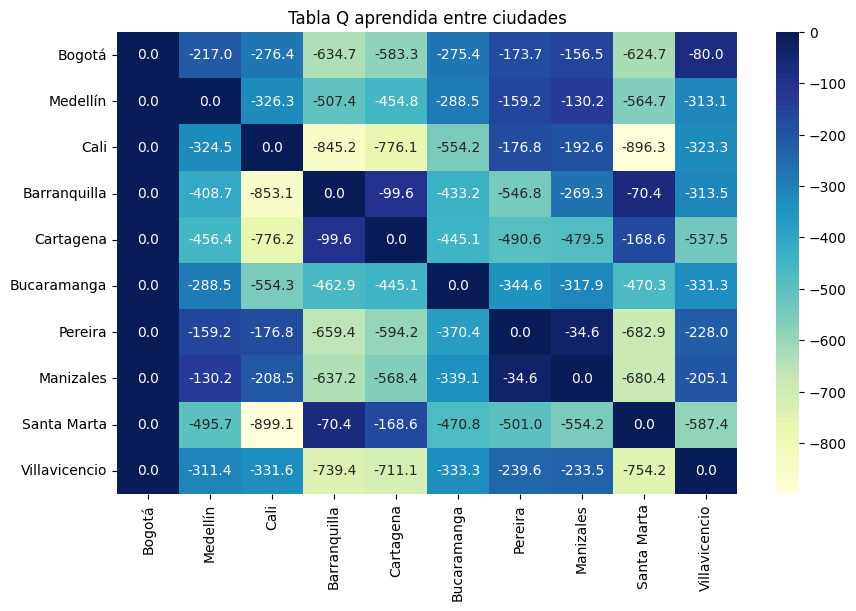

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(q_table, annot=True, cmap='YlGnBu', fmt='.1f', xticklabels=df['Ciudad'], yticklabels=df['Ciudad'])
plt.title('Tabla Q aprendida entre ciudades')
plt.show()

## 🧭 Paso 7: Ruta óptima desde Bogotá (Q-Learning)

In [7]:
estado = 0
ruta = [estado]
visitados = set(ruta)
while len(visitados) < n_ciudades:
    opciones = [i for i in range(n_ciudades) if i not in visitados]
    accion = opciones[np.argmax(q_table[estado, opciones])]
    ruta.append(accion)
    visitados.add(accion)
    estado = accion

# Mostrar ruta óptima
print('Ruta óptima sugerida:')
for idx in ruta:
    print('🟢', df.loc[idx, 'Ciudad'])

Ruta óptima sugerida:
🟢 Bogotá
🟢 Villavicencio
🟢 Manizales
🟢 Pereira
🟢 Medellín
🟢 Bucaramanga
🟢 Cartagena
🟢 Barranquilla
🟢 Santa Marta
🟢 Cali
